In [19]:
import numpy
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
def plot_simulation(loan_amount, months, interest_rate, monthly_fees=0, extra_payments=0, prepay_penalties=0.01, extra_payment_reduce_term=True, show=False):
    """
    Simulate a fixed-rate mortgage (FRM)
    :param loan_amount: 
        initial loan balance
    :param months: 
        term of mortgage in months
    :param interest_rate: 
        annual percentage of the remaining loan balance
    :param monthly_fees:
        monthly fees like house/life insurance
    :param extra_payments:
        optional; if a number, then monthly extra payments; if a list, then the corresponding months' payment value
    :param prepay_penalties:
        optional; in case of montly extra payments (e.g. 0.01 means 1% of the prepaid value)
    :param extra_payment_reduce_term:
        optional; in case of montly extra payments; True: keep the rate fixed, False: reduce the rate
    :param show:
        show plot of cumulative principal and cumulative interest
    :return: 
        pd.DataFrame
        [
            [no. month, loan balance, monthly payment = P + I + F (fee), principal (P), interest (I), cumulative principal, cumulative interest],
            ...
        ]
    """

    cumulative_interest = 0
    cumulative_principal = 0
    fees = 0
    
    data = []
    balance = loan_amount
    
    
    
    # Excel.PMT function
    monthly_payment = -npf.pmt(interest_rate / 12, months, loan_amount)
    
    TITLE_MONTHLY_PAYMENT = f"* monthly payment: {monthly_payment:0.2f} + {monthly_fees:.2f} fee = {monthly_payment+monthly_fees:0.2f} \n"
    
    for i in range(months):
        if balance <= 0:
            break
            
        # Recalc. interest after initial period of 10 years for e.g.
        if i == 10 * 12 - 1:
            interest_rate = 4.47 / 100
#             monthly_payment = -npf.pmt(interest_rate / 12, months - i, balance)
            TITLE_MONTHLY_PAYMENT += f"* monthly payment: {monthly_payment:0.2f} + {monthly_fees:.2f} fee = {monthly_payment+monthly_fees:0.2f} [after 10y]\n"
            
            
            
        interest = balance * (interest_rate / 12)
        principal = min(balance, monthly_payment - interest)
        balance -= principal
        
        if balance > 0 and extra_payments:
            
            # ================
            # Handle optional extra payment
            # ================
            extra = 0
            
            if isinstance(extra_payments, list):
                if i < len(extra_payments):
                    extra = extra_payments[i]
            elif isinstance(extra_payments, (int, float)):
                extra = extra_payments
                  
            if extra:
                extra = min(balance, extra * (1 - prepay_penalties)) # prepay penalties aka. commission / fee
                principal += extra
                balance -= extra

                if not extra_payment_reduce_term:
                    monthly_payment = -npf.pmt(interest_rate / 12, months - i, balance)
        
        
        cumulative_principal += principal
        cumulative_interest += interest
        fees += monthly_fees
        
        data.append([i + 1, balance, monthly_payment + monthly_fees, principal, interest, cumulative_principal, cumulative_interest])
        
    df_data = pd.DataFrame(data, columns=[
        "Month", 
        "Remaining Balance", 
        "Montly payment = P + I", 
        "Principal (P)", 
        "Interest (I)", 
        "Cumulative P",
        "Cumulative I"])
        
    payments = len(df_data)
    years = payments // 12
    
    plt.title(f"{payments} payments ({years}y, {payments - years  *12}m)\n"
              f"* loan amount: {loan_amount:.2f}, yearly interest rate: {interest_rate * 100:0.4f}%\n"
              f"{TITLE_MONTHLY_PAYMENT}"
              f"* total fees: {fees:0.2f} \n"
              f"* total interest:  {df_data['Cumulative I'].iloc[-1]:0.2f}\n"
              f"* total principal: {df_data['Cumulative P'].iloc[-1]:0.2f}", loc="left")
    X = list(range(len(df_data)))
    plt.plot(X, df_data["Cumulative I"], label="Cumulative interest", c="g" if extra_payments else "r")
    plt.plot(X, df_data["Cumulative P"], label="Cumulative principal", c="b")
    plt.ylabel("Value")
    plt.xlabel("Month")
    plt.legend()
    
    if show:
        plt.show()
        
    return df_data
    
def plot_full_simulation(loan_amount, months, interest_rate, monthly_fees=0, extra_payments=0, prepay_penalties=0.01, extra_payment_reduce_term=True):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    df_data = plot_simulation(loan_amount, months, interest_rate, monthly_fees)
    data = [df_data]
    if extra_payments:
        plt.subplot(132)
        df_data2 = plot_simulation(loan_amount, months, interest_rate, monthly_fees, extra_payments, prepay_penalties, extra_payment_reduce_term)
        data.append(df_data2)
        
        plt.subplot(133)
        diff = df_data["Cumulative I"].iloc[-1] - \
               df_data2["Cumulative I"].iloc[-1]
        plt.title(f"Difference in interest: {diff:.2f}")
        plt.bar([0], [loan_amount], label="A. Loan amount")
        plt.bar([1], [df_data["Cumulative I"].iloc[-1]], label="B. Total interest after loan term", color="r")
        plt.bar([2], [df_data2["Cumulative I"].iloc[-1]], label="C. (B) with monthly extra payments", color="green")
        plt.ylabel("Value")
        plt.xticks([0, 1, 2], ["Loan amount", "B. Interest", "C. Interest"])
        plt.legend()
    plt.show()
    
    return data

In [21]:
# df = plot_full_simulation(380000, 210, (4.88) / 100, monthly_fees=47.5, extra_payments=0, prepay_penalties=0.00, extra_payment_reduce_term=True)

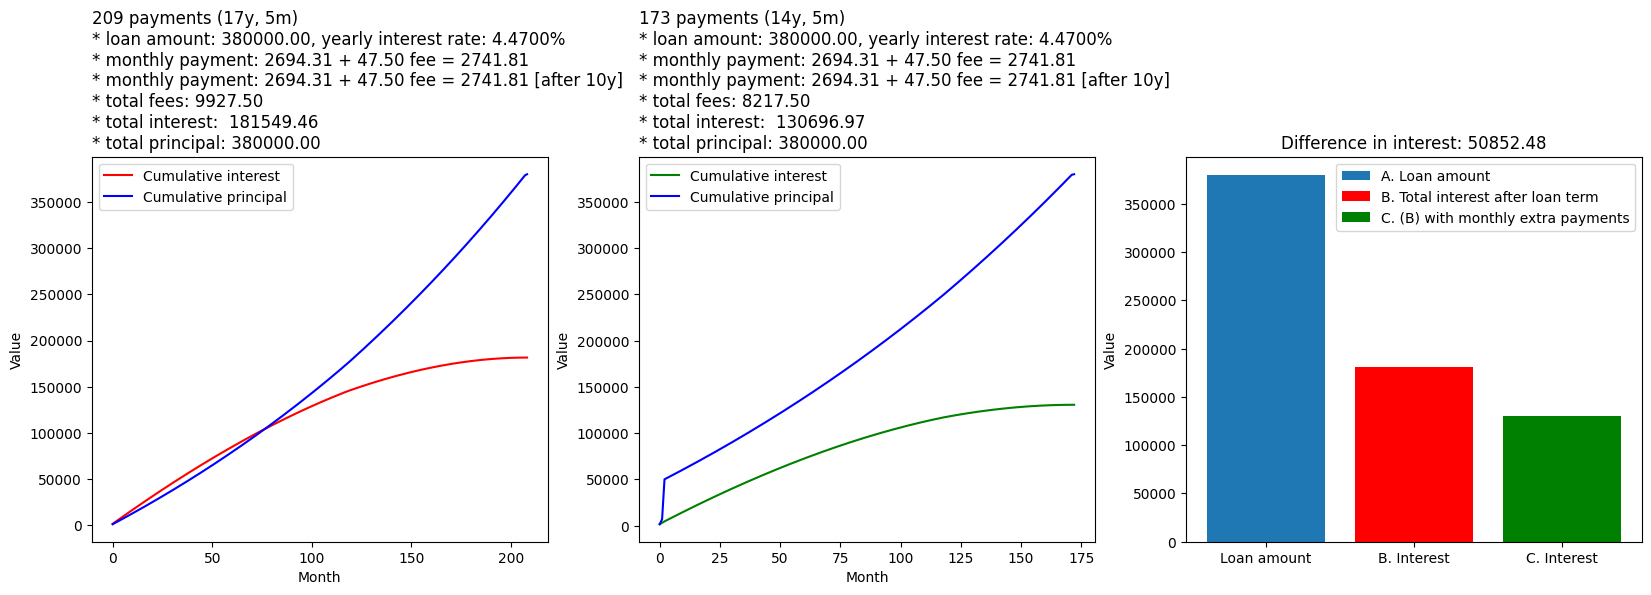

In [22]:
df = plot_full_simulation(380000, 210, (4.88) / 100, monthly_fees=47.5, extra_payments=[42 * 10, 42 * 100, 42 * 1000], prepay_penalties=0.00, extra_payment_reduce_term=True)

In [4]:
df[0]

,Month,Remaining Balance,Montly payment = P + I,Principal (P),Interest (I),Cumulative P,Cumulative I
0,1,378851.018878,2694.314455,1148.981122,1545.333333,1148.981122,1545.333333
1,2,377697.365233,2694.314455,1153.653645,1540.660810,2302.634767,3085.994143
2,3,376539.020063,2694.314455,1158.345170,1535.969285,3460.979937,4621.963429
3,4,375375.964290,2694.314455,1163.055774,1531.258682,4624.035710,6153.222110
4,5,374208.178756,2694.314455,1167.785534,1526.528921,5791.821244,7679.751032
...,...,...,...,...,...,...,...
205,206,10668.573891,2694.314455,2640.192140,54.122315,369331.426109,185697.351663
206,207,8017.644970,2694.314455,2650.928921,43.385534,371982.355030,185740.737197
207,208,5355.935604,2694.314455,2661.709366,32.605090,374644.064396,185773.342286
208,209,2683.401954,2694.314455,2672.533650,21.780805,377316.598046,185795.123091
